#SYMPHOMY AI
# Machine Learning Project -  [CarTrade Car Dataset]
Problem Statement 'Car-Dataset is used to classify the car acceptability into classes: unacceptable, acceptable, good and very good.'

In [ ]:
# !pip install yellowbrick

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as dataSplitter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
from yellowbrick.classifier import ROCAUC


# From the initial EDA analysis of the dataset

### Mapping:
1. Numeric datatype to float/int 
2. Categorical dataype to object dtype

## 2. Pre-Processing

#### *check and perform following preprocessing steps*
1. Replace if any not legal values like "?" by numpy.NaN
2. strip whitspace (tabs, newline, space)
3. Convert numeric data-type from object dtype to numeric/float dtype
4. Convert nominal values to binary values

- *Numeric Variable: Data contains categorical variables*
- *Categorical (binary/nominal Variable):  ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']*

5. Descriptive statistics and checking null value

6. If Missing value than imputation by following logic: 
- KNNImputer with neighbour: 5 - for Numeric variable
- mode imputation for Categorical/Niminal variable

7. #Scaling and normalization of features
- Numerical variable: Standardize using z-score (StandardScaler) normalization 
- Categorical variable: categorical variables are not normalize (to avoid loosing the nature of categorical variable), hence creating dummy variables/ one-hot encoding for categorical features

8. #Encoding target class using label encoding
- class 0: acc (384)
- class 1: good (69)
- class 2: unacc (1210)
- class 3: vgood (65)


Shape of dataset: (1728, 7)
Total number of records in dataset = 1728
Total number of attributes in dataset = 7

There is no missing values in the dataset.


Data Top Head
  buying  maint doors persons lug_boot safety classNames
0  vhigh  vhigh     2       2    small    low      unacc
1  vhigh  vhigh     2       2    small    med      unacc
2  vhigh  vhigh     2       2    small   high      unacc
3  vhigh  vhigh     2       2      med    low      unacc
4  vhigh  vhigh     2       2      med    med      unacc


{'buying': ['vhigh', ' high', ' med', ' low.'], 'maint': ['vhigh', ' high', ' med', ' low.'], 'doors': ['2', ' 3', ' 4', ' 5more.'], 'persons': ['2', ' 4', ' more.'], 'lug_boot': ['small', ' med', ' big.'], 'safety': ['low', ' med', ' high.']} ['unacc', 'acc', 'good', 'vgood']


Data Description
       buying maint doors persons lug_boot safety classNames
count    1728  1728  1728    1728     1728   1728       1728
unique      4     4     4       3        3      3          4
top 

<ipython-input-3-0c54ed3042a8>:83: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



Are there missing values in Target Class? False

Are there missing values in the Features? 
buying        False
maint         False
doors         False
persons       False
lug_boot      False
safety        False
classNames    False
dtype: bool

Now, Are there any missing values in Features? buying_low        False
buying_med        False
buying_vhigh      False
maint_low         False
maint_med         False
maint_vhigh       False
doors_3           False
doors_4           False
doors_5more       False
persons_4         False
persons_more      False
lug_boot_med      False
lug_boot_small    False
safety_low        False
safety_med        False
dtype: bool


target class-categorization
2    1210
0     384
1      69
3      65
dtype: int64


train and test split
(1382, 15) (346, 15) (1382,) (346,)


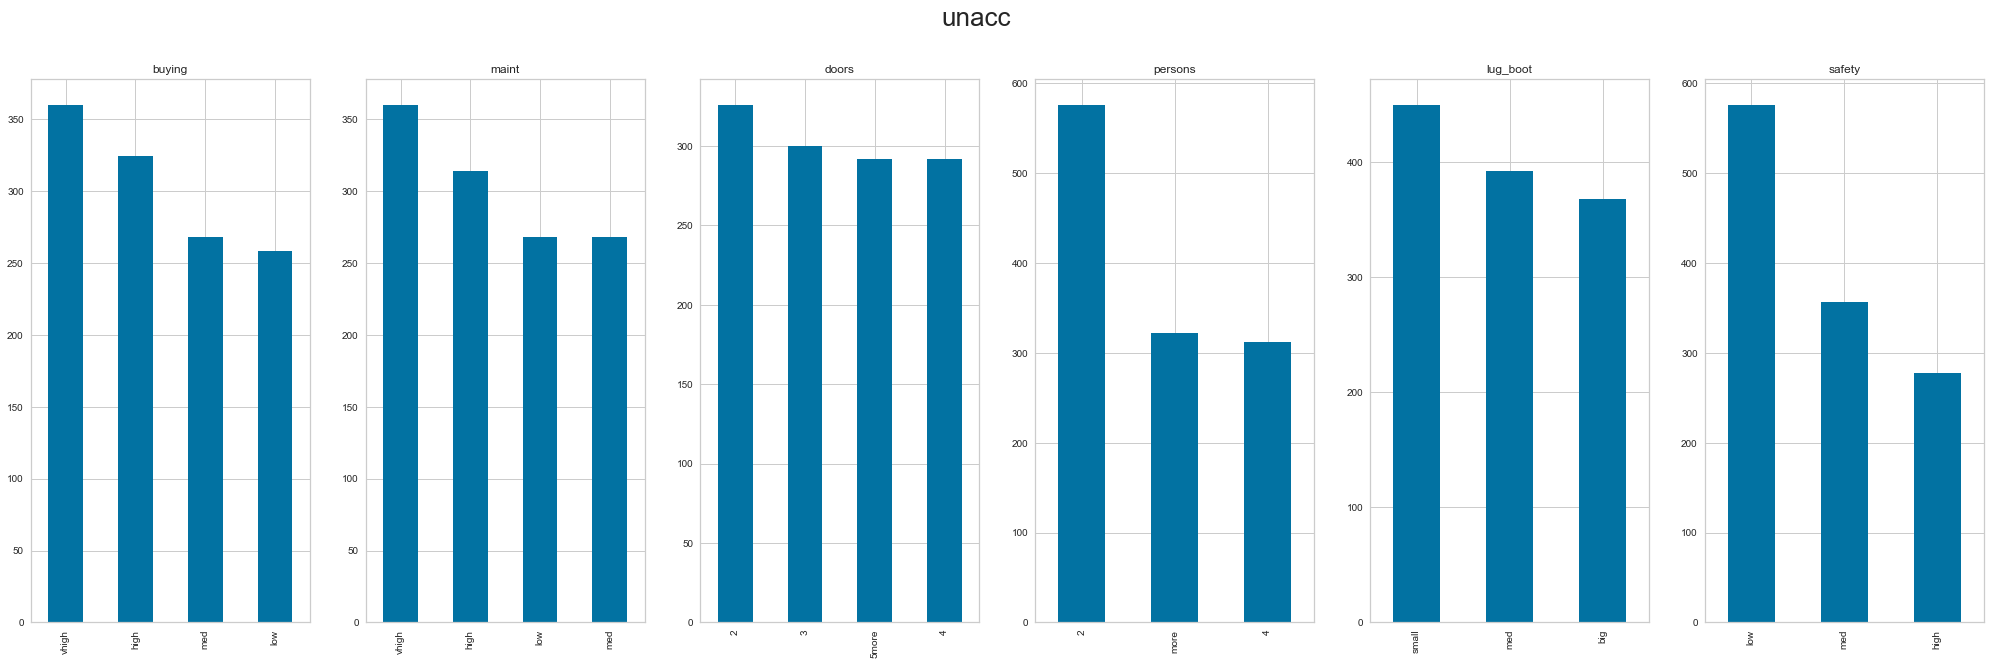

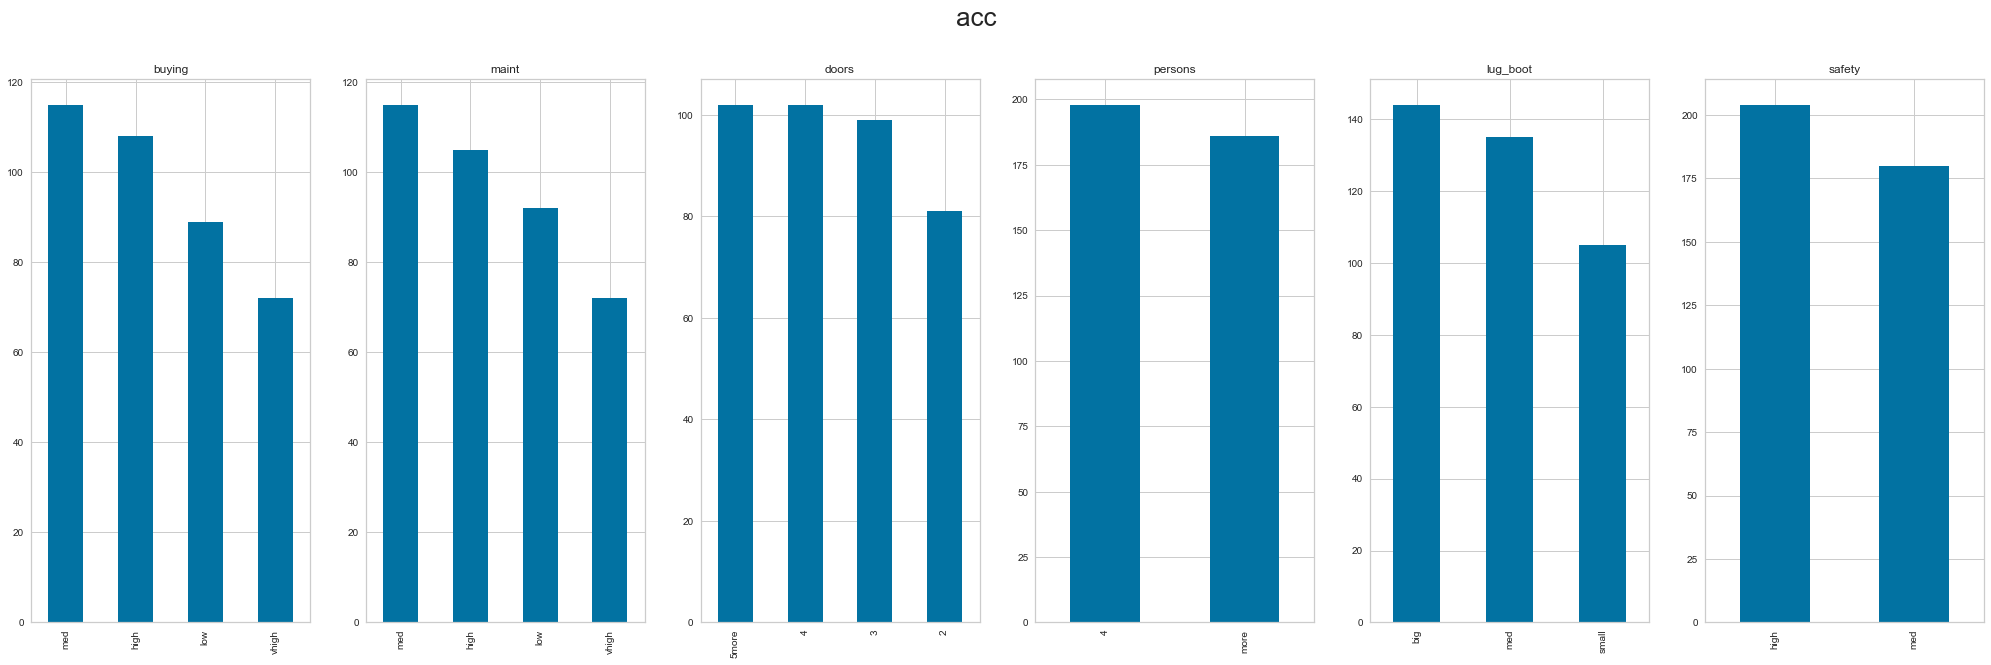

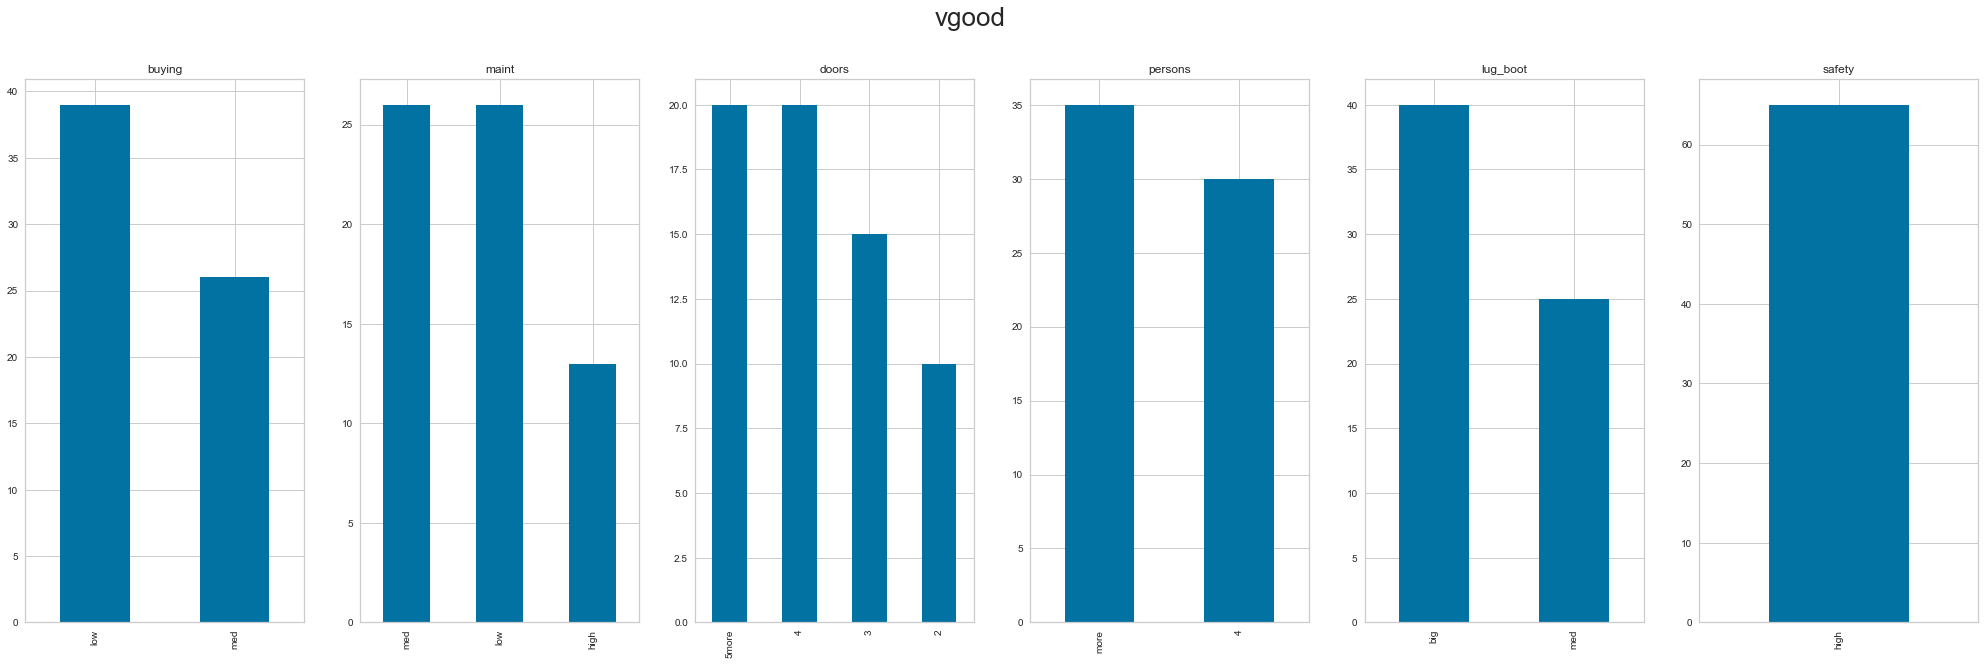

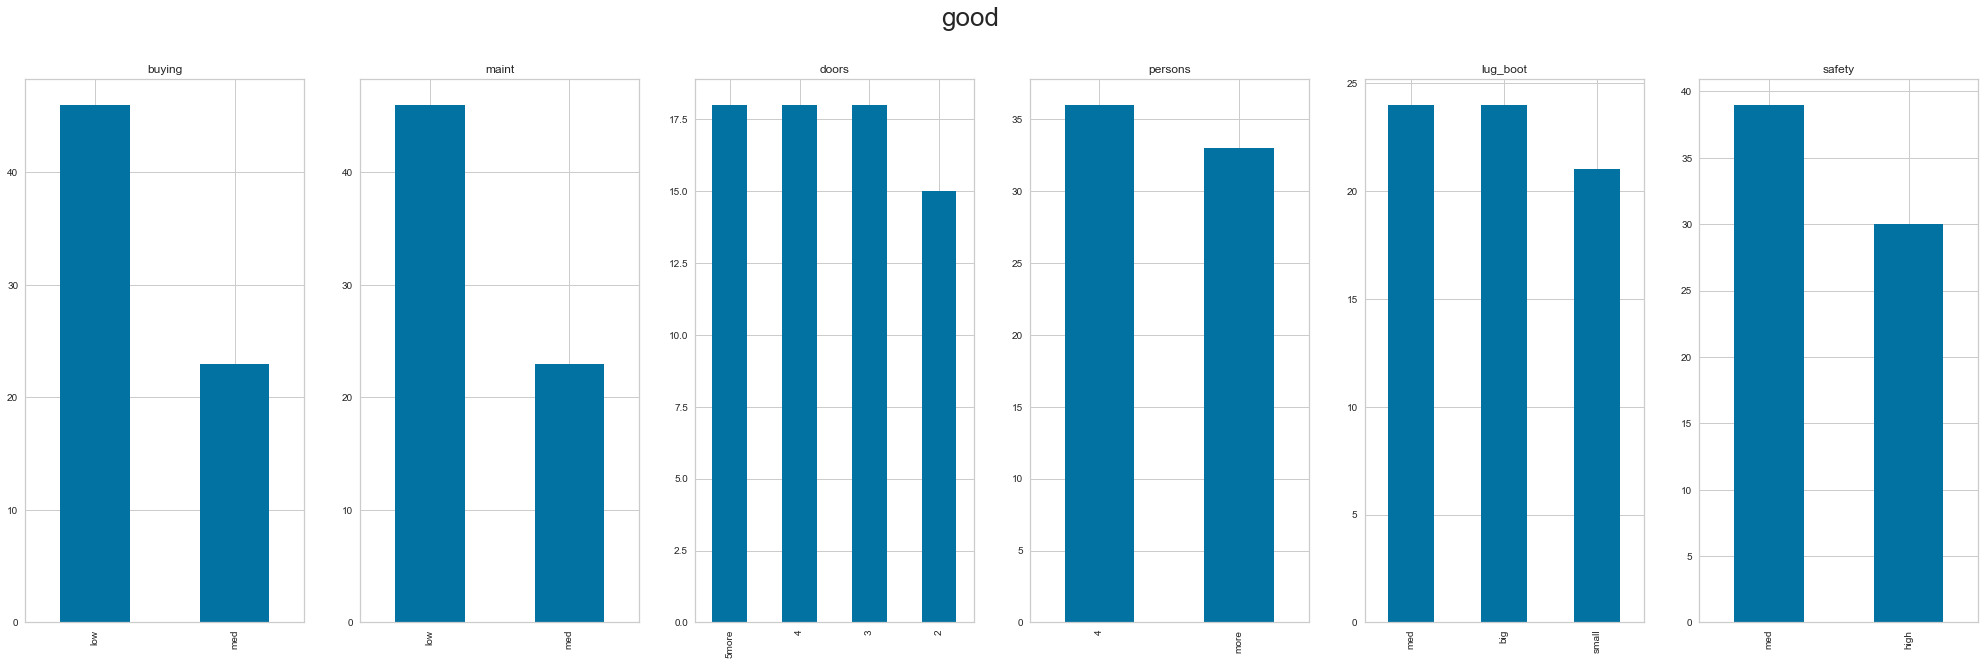

In [ ]:
#Create function for checking missing values which accepts a dataframe as its parameter
def null_values_check(df): 
    #Error handling to prevent abnormal termination of operation
    try:
        if(df.isnull().values.any() == True):
            #if there are null values present, print a column-wise summary of records with null values
            print('Number of null records within each column:\n' + str(df.isnull().sum()))
        else:
            print('There is no missing values in the dataset.')
    
    except Exception as e:
        logging.error(e)


#error-handling to prevent abnormal termination of code
try:
    #import and load car dataset into pandas dataframe
    
    # Read Data
    classNames, colNames, colValues = None, [], {}
    with open('car.c45-names', 'r') as clsFile:
        for l in clsFile:
            l = l.strip().lower()
            if len(l) <= 1 or l[0] == '|': continue
            if classNames is None: 
                classNames = [i.strip().lower() for i in l.split(',')]
                continue
            colNames.append(l[:l.index(':')])
            l = l[l.index(':')+1:].strip().lower()
            colValues[colNames[-1]] = l.split(',')
            pass
        pass

    # The Data Is Basically a CSV 
    with open('car.data', 'r') as dataFile: carData = pd.DataFrame([l.strip().lower().split(',') for l in dataFile], columns=colNames+['classNames']) 

    # Check and Replace if "?" by numpy.NaN
    carData = carData.replace("?", np.NaN)

    # Convert numeric data-type from object dtype to numeric/float dtype
    cols_numeric = list(carData.select_dtypes(include='number'))
    carData[cols_numeric] = carData[cols_numeric].apply(pd.to_numeric, errors='coerce', axis=1)
    
    #Description of Datasets
    #Print number of records and attributes of whole car dataset
    print('Shape of dataset: ' + str(carData.shape))
    print('Total number of records in dataset = ' + str(carData.shape[0]))
    print('Total number of attributes in dataset = ' + str(carData.shape[1]))
    print('')
    #call function created to check for null values
    null_values_check(carData)
    print("\n")
    print("Data Top Head")
    print(carData.head())
    print("\n")
    print(colValues, classNames)
    print("\n")
    print("Data Description")
    print(carData.describe())
    
    # There aren't any NaN's, but lets handle the case any way for the sake of genralization.
    # Lets replace any NaN's or Empty Strings ('') with the most frequently occuring
    # value in that column.
    # A better strategy here might be simply dropping the rows that are NaN valued as the
    # above mentioned method might end up generating Outliers. 

    # Replace NaN's and '' with the most frequent value.
    for c in colNames:
        changeValues = carData[c].isna() | (carData[c] == '')
        if not changeValues.any(): continue
        maxFreq = carData[c].value_counts().idxmax()
        carData[c][changeValues] = maxFreq

    print("-------------------------------------------------------------------")
    plt.rcParams.update({'font.size': 22})

    for tclass in carData['classNames'].unique():
        fig, ax = plt.subplots(1, len(carData.columns)-1, figsize=(35, 10))
        fig.suptitle(tclass, fontsize=26)
        # thisClass = carData[carData['classNames'] == tclass ]
        for i, c in enumerate(list(carData.columns)[:-1]):
            carData[carData['classNames'] == tclass ][c].value_counts().plot(kind="bar", ax=ax[i]).set_title(c) 
        fig.show()

    #set the features and the target variables
    target_class = carData['classNames']
    print('\nAre there missing values in Target Class? ' + str(target_class.isna().any()))
    feature_classes = carData
    print('\nAre there missing values in the Features? \n' + str(feature_classes.isna().any()))
    

    carData.drop('classNames', axis=1, inplace=True)

    binary_var = list(carData.select_dtypes(include='object'))

    #Missing value imputation for numeric variables
    #KNN imputation (n_neighbour = 5 means that the missing values will be replaced by the mean value of 5 nearest neighbors)
    if cols_numeric:
        knn_missing_values_imputer = KNNImputer(n_neighbors=5)
        feature_classes_ = pd.DataFrame(knn_missing_values_imputer.fit_transform(feature_classes[cols_numeric]),
                                       columns = cols_numeric)
    else:
        pass

#     #Scaling and normalization of features
#     standard_feature_scaler = StandardScaler()
#     feature_classes_ = standard_feature_scaler.fit_transform(feature_classes_)
#     feature_classes_ = pd.DataFrame(feature_classes_, columns=cols_numeric)


    #Missing value imputation for categorical variables using mode
    if binary_var:
        for column in feature_classes[binary_var]:
            mode = feature_classes[column].mode()
            feature_classes[column] = feature_classes[column].fillna(mode[0])
        binary_df = feature_classes[binary_var]
        binary_df = pd.get_dummies(binary_df, drop_first=True)
     
    if binary_var and cols_numeric:
        feature_classes = pd.concat([feature_classes_ ,binary_df], axis=1)
    elif cols_numeric:
        feature_classes = feature_classes_
    else:
        feature_classes = binary_df
        

    print('\nNow, Are there any missing values in Features? ' + str(feature_classes.isna().any()))
    
    #Encoding target class using label encoding
    target_label_encoder = preprocessing.LabelEncoder()
    target_class = target_label_encoder.fit_transform(target_class)
    print("\n")
    print("target class-categorization")
    print(pd.Series(target_class).value_counts())
    target_class = pd.DataFrame(target_class, columns=['classNames'])
    target_class['classNames'] = target_class['classNames'].astype(int)
    print("\n")
    print("train and test split")
    trainX, testX, trainY, testY = dataSplitter(feature_classes, target_class['classNames'],
                                           test_size=0.20, random_state=10)
    
    print(trainX.shape, testX.shape, trainY.shape, testY.shape)
except FileNotFoundError as e:
    logging.error(e)

correlation analysis


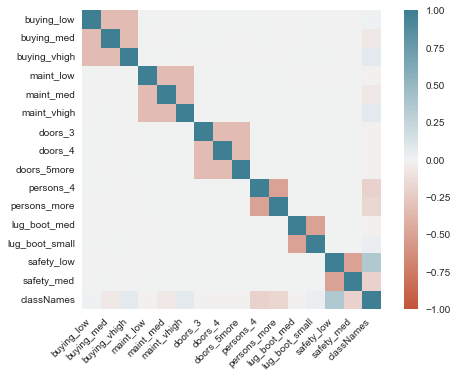

In [ ]:
print("correlation analysis")
corr = pd.concat([feature_classes, target_class], axis=1).corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

## Machine Learning Model Building and Result

1. #### Logistic Regressor

Performance Metric

Precision: 0.8887448218351327
Accuracy: 0.8670520231213873
Recall: 0.8670520231213873
F1-score: 0.8509838123079072

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.88      0.71        64
           1       0.50      0.15      0.24        13
           2       0.98      0.96      0.97       251
           3       1.00      0.11      0.20        18

    accuracy                           0.87       346
   macro avg       0.77      0.52      0.53       346
weighted avg       0.89      0.87      0.85       346


Confusion Matrix: 
[[ 56   2   6   0]
 [ 11   2   0   0]
 [ 11   0 240   0]
 [ 16   0   0   2]]


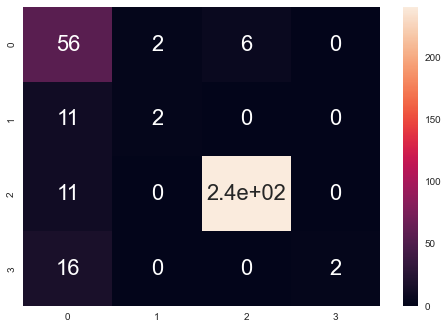

In [ ]:
# The trained logistic model is good, but we can do better. As we know, that our data is 
# purely categorical, a decision based model migt perform better. With this assumption,

logModel = LogisticRegression(multi_class='ovr').fit(trainX, trainY)
#logModel.score(trainX, trainY), logModel.score(testX, testY)

print("Performance Metric")
#predict value
dt_prediction = logModel.predict(testX)

#display classification Metrices for Logistic Model
print('\nPrecision: ' + str(metrics.precision_score(testY, dt_prediction, average='weighted')))
print('Accuracy: ' + str(metrics.accuracy_score(testY, dt_prediction)))
print('Recall: ' + str(metrics.recall_score(testY, dt_prediction, average='weighted')))
print('F1-score: ' + str(metrics.f1_score(testY, dt_prediction, average='weighted')))

#display classification report for svm-rbf
print('\nClassification Report:\n' + str(metrics.classification_report(testY, dt_prediction)))

#display confusion matrix
print('\nConfusion Matrix: \n' + str(metrics.confusion_matrix(testY, dt_prediction)))
#plot confusion matrix
sns.heatmap(metrics.confusion_matrix(testY, dt_prediction), annot = True)
plt.show()

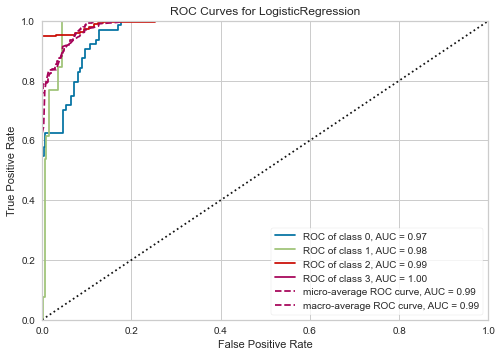

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
visualizer = ROCAUC(logModel)

visualizer.fit(trainX, trainY)        # Fit the training data to the visualizer
visualizer.score(testX, testY)        # Evaluate the model on the test data
visualizer.show()      

2. #### RandomForestClassifier

Performance Metric

Precision: 0.9084679038637055
Accuracy: 0.9046242774566474
Recall: 0.9046242774566474
F1-score: 0.9019188206002814

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        64
           1       0.40      0.31      0.35        13
           2       0.97      0.97      0.97       251
           3       1.00      0.56      0.71        18

    accuracy                           0.90       346
   macro avg       0.78      0.68      0.71       346
weighted avg       0.91      0.90      0.90       346


Confusion Matrix: 
[[ 56   2   6   0]
 [  8   4   1   0]
 [  8   0 243   0]
 [  4   4   0  10]]


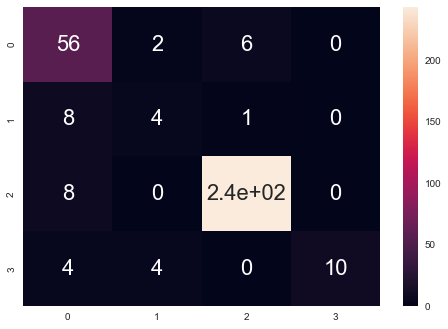

In [ ]:
# Decision based classifier have performed better than Logistic Model

forModel = RandomForestClassifier(max_depth=10).fit(trainX, trainY) # max_features=20
#forModel.score(trainX, trainY), forModel.score(testX, testY)
#predict value
dt_prediction = forModel.predict(testX)
print("Performance Metric")

#display classification Metrices for Logistic Model
print('\nPrecision: ' + str(metrics.precision_score(testY, dt_prediction, average='weighted')))
print('Accuracy: ' + str(metrics.accuracy_score(testY, dt_prediction)))
print('Recall: ' + str(metrics.recall_score(testY, dt_prediction, average='weighted')))
print('F1-score: ' + str(metrics.f1_score(testY, dt_prediction, average='weighted')))

#display classification report for svm-rbf
print('\nClassification Report:\n' + str(metrics.classification_report(testY, dt_prediction)))

#display confusion matrix
print('\nConfusion Matrix: \n' + str(metrics.confusion_matrix(testY, dt_prediction)))
#plot confusion matrix
sns.heatmap(metrics.confusion_matrix(testY, dt_prediction), annot = True)
plt.show()

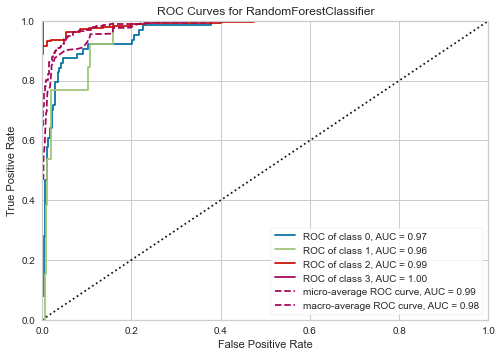

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
visualizer = ROCAUC(forModel)

visualizer.fit(trainX, trainY)        # Fit the training data to the visualizer
visualizer.score(testX, testY)        # Evaluate the model on the test data
visualizer.show()      

3. #### KNeighborsClassifier

Performance Metric

Precision: 0.8589567040689108
Accuracy: 0.8554913294797688
Recall: 0.8554913294797688
F1-score: 0.8448034655571407

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.81      0.73        64
           1       0.25      0.15      0.19        13
           2       0.93      0.94      0.94       251
           3       1.00      0.28      0.43        18

    accuracy                           0.86       346
   macro avg       0.71      0.55      0.57       346
weighted avg       0.86      0.86      0.84       346


Confusion Matrix: 
[[ 52   3   9   0]
 [  8   2   3   0]
 [ 14   0 237   0]
 [  4   3   6   5]]


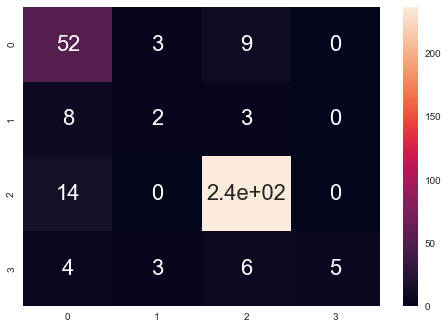

In [ ]:
knnModel = KNeighborsClassifier(target_class['classNames'].max()+1).fit(trainX, trainY)
#knnModel.score(trainX, trainY), knnModel.score(testX, testY)

#predict value
dt_prediction = knnModel.predict(testX)
print("Performance Metric")

#display classification Metrices for Logistic Model
print('\nPrecision: ' + str(metrics.precision_score(testY, dt_prediction, average='weighted')))
print('Accuracy: ' + str(metrics.accuracy_score(testY, dt_prediction)))
print('Recall: ' + str(metrics.recall_score(testY, dt_prediction, average='weighted')))
print('F1-score: ' + str(metrics.f1_score(testY, dt_prediction, average='weighted')))

#display classification report for svm-rbf
print('\nClassification Report:\n' + str(metrics.classification_report(testY, dt_prediction)))

#display confusion matrix
print('\nConfusion Matrix: \n' + str(metrics.confusion_matrix(testY, dt_prediction)))
#plot confusion matrix
sns.heatmap(metrics.confusion_matrix(testY, dt_prediction), annot = True)
plt.show()

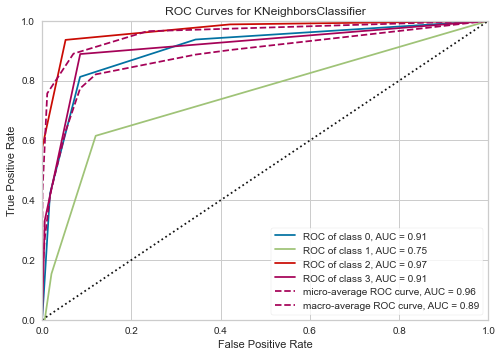

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
visualizer = ROCAUC(knnModel)

visualizer.fit(trainX, trainY)        # Fit the training data to the visualizer
visualizer.score(testX, testY)        # Evaluate the model on the test data
visualizer.show()      

4. #### svmModel "polynomial kernel"

Performance Metric

Precision: 0.9807173558618645
Accuracy: 0.9797687861271677
Recall: 0.9797687861271677
F1-score: 0.9796595280867361

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95        64
           1       0.87      1.00      0.93        13
           2       1.00      1.00      1.00       251
           3       1.00      0.83      0.91        18

    accuracy                           0.98       346
   macro avg       0.95      0.95      0.94       346
weighted avg       0.98      0.98      0.98       346


Confusion Matrix: 
[[ 61   2   1   0]
 [  0  13   0   0]
 [  1   0 250   0]
 [  3   0   0  15]]


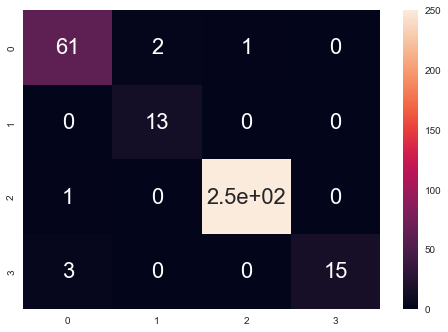

In [ ]:
# SVM with Poly or RBF kernels performs better than with other kernels like linear
# as well as better than other models. Random Forest being the only one that comes close.

svmModel = SVC(kernel='poly').fit(trainX, trainY)
#svmModel.score(trainX, trainY), svmModel.score(testX, testY)

#predict value
dt_prediction = svmModel.predict(testX)
print("Performance Metric")

#display classification Metrices for Logistic Model
print('\nPrecision: ' + str(metrics.precision_score(testY, dt_prediction, average='weighted')))
print('Accuracy: ' + str(metrics.accuracy_score(testY, dt_prediction)))
print('Recall: ' + str(metrics.recall_score(testY, dt_prediction, average='weighted')))
print('F1-score: ' + str(metrics.f1_score(testY, dt_prediction, average='weighted')))

#display classification report for svm-rbf
print('\nClassification Report:\n' + str(metrics.classification_report(testY, dt_prediction)))

#display confusion matrix
print('\nConfusion Matrix: \n' + str(metrics.confusion_matrix(testY, dt_prediction)))
#plot confusion matrix
sns.heatmap(metrics.confusion_matrix(testY, dt_prediction), annot = True)
plt.show()

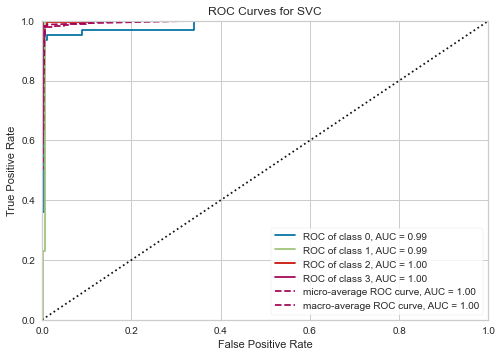

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
visualizer = ROCAUC(svmModel)

visualizer.fit(trainX, trainY)        # Fit the training data to the visualizer
visualizer.score(testX, testY)        # Evaluate the model on the test data
visualizer.show()      

5. #### svmModel "polynomial kernel"

Performance Metric

Precision: 0.9605330722235511
Accuracy: 0.9595375722543352
Recall: 0.9595375722543352
F1-score: 0.9595800978133876

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        64
           1       0.83      0.77      0.80        13
           2       0.99      0.98      0.99       251
           3       0.94      0.83      0.88        18

    accuracy                           0.96       346
   macro avg       0.91      0.88      0.89       346
weighted avg       0.96      0.96      0.96       346


Confusion Matrix: 
[[ 60   2   2   0]
 [  2  10   0   1]
 [  4   0 247   0]
 [  3   0   0  15]]


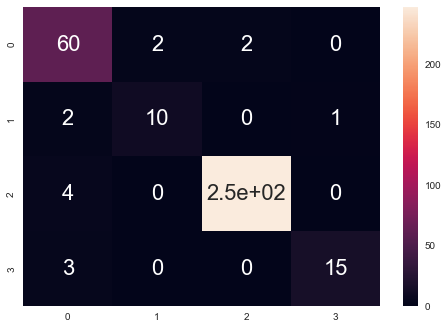

In [ ]:
svmModel = SVC(kernel='rbf').fit(trainX, trainY)
#svmModel.score(trainX, trainY), svmModel.score(testX, testY)

#predict value
dt_prediction = svmModel.predict(testX)
print("Performance Metric")

#display classification Metrices for Logistic Model
print('\nPrecision: ' + str(metrics.precision_score(testY, dt_prediction, average='weighted')))
print('Accuracy: ' + str(metrics.accuracy_score(testY, dt_prediction)))
print('Recall: ' + str(metrics.recall_score(testY, dt_prediction, average='weighted')))
print('F1-score: ' + str(metrics.f1_score(testY, dt_prediction, average='weighted')))

#display classification report for svm-rbf
print('\nClassification Report:\n' + str(metrics.classification_report(testY, dt_prediction)))

#display confusion matrix
print('\nConfusion Matrix: \n' + str(metrics.confusion_matrix(testY, dt_prediction)))
#plot confusion matrix
sns.heatmap(metrics.confusion_matrix(testY, dt_prediction), annot = True)
plt.show()

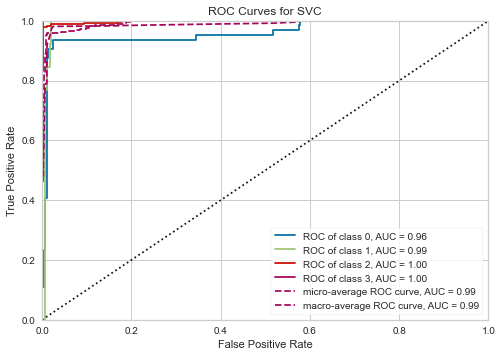

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
visualizer = ROCAUC(svmModel)

visualizer.fit(trainX, trainY)        # Fit the training data to the visualizer
visualizer.score(testX, testY)        # Evaluate the model on the test data
visualizer.show()      

### Result Analysis-

From the four model used for analysis, we have found:
SVM (RBF and Polynomial) kernel based model perform good compared to Logistic, KNN, and Random Forest model-- based on the computed:

1. **weighted precision value of:**
* 98%: Polynomial kernel svm
* 96%: RBF kernel based svm 
2. **weighted accuracy value of:**
* 98%: Polynomial kernel svm
* 96%: RBF kernel based svm 

We have also found Randome Forest performance is comparable with SVM model output.

* For the production environment, we could deploy SVM based kernel method for car dataset classification 